<b>40 years of research on eating disorders: Bibliometrics, network analysis, and topic modeling</b>
<br><a href='https://github.com/almenaraio'>Carlos A. Almenara</a>, Feb-2021
<br>(Python code based on multiple sources)

In [1]:
import os
import pickle
from pprint import pprint

import pandas as pd
import numpy as np

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg # To import AllenAI scispaCy model you must download it first

import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, nmf
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF, TruncatedSVD # decomposition for LSA
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set working directory
os.chdir('C:/temp/eating')

In [3]:
# Loading our collection of records gathered from Scopus
"""
NOTE: Due to copyright is not possible to share this dataset
To replicate the download of this dataset read the procedure in the paper
and follow these instructions:
https://www.bibliometrix.org/vignettes/Introduction_to_bibliometrix.html
"""
df = pd.read_csv('eating_disorders_literature.csv') # dtype={'DOI': str, 'Pubmed ID': str})

In [4]:
df.head()

,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,...,Language of Original Document,Abbreviated Source Title,Document Type,Publication Stage,Access Type,Source,EID,Funding Text 4,Funding Text 5,Funding Text 6
0,"Smith K.E., Mason T.B., Juarascio A., Weinbach...",55507492500;56168408500;35753736200;5026340640...,"The momentary interplay of affect, attention b...",2020,International Journal of Eating Disorders,53.0,4.0,NaN,586.0,594.0,...,English,Int. J. Eating Disord.,Article,Final,NaN,Scopus,2-s2.0-85083535660,NaN,NaN,NaN
1,"Van Huysse J.L., Smith K., Mammel K.A., Prohas...",57211692842;57211683813;6507569120;57216448773...,Early weight gain predicts treatment response ...,2020,International Journal of Eating Disorders,53.0,4.0,NaN,606.0,610.0,...,English,Int. J. Eating Disord.,Article,Final,NaN,Scopus,2-s2.0-85083531378,NaN,NaN,NaN
2,"Aulinas A., Marengi D.A., Galbiati F., Asanza ...",42560893700;55880518800;57215846471;5719529853...,Medical comorbidities and endocrine dysfunctio...,2020,International Journal of Eating Disorders,53.0,4.0,NaN,631.0,636.0,...,English,Int. J. Eating Disord.,Article,Final,NaN,Scopus,2-s2.0-85082032867,NaN,NaN,NaN
3,"Mensinger J.L., Granche J.L., Cox S.A., Henret...",21834046800;57209779245;57214602781;24464002600;,Sexual and gender minority individuals report ...,2020,International Journal of Eating Disorders,53.0,4.0,NaN,541.0,554.0,...,English,Int. J. Eating Disord.,Article,Final,Open Access,Scopus,2-s2.0-85081724543,NaN,NaN,NaN
4,"Zucker N.L., Bulik C.M.",8367933200;56827294000;,"On bells, saliva, and abdominal pain or discom...",2020,International Journal of Eating Disorders,53.0,4.0,NaN,508.0,512.0,...,English,Int. J. Eating Disord.,Article,Final,NaN,Scopus,2-s2.0-85081575634,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8651 entries, 0 to 8650
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Authors                        8651 non-null   object 
 1   Author(s) ID                   8651 non-null   object 
 2   Title                          8651 non-null   object 
 3   Year                           8651 non-null   int64  
 4   Source title                   8651 non-null   object 
 5   Volume                         8324 non-null   float64
 6   Issue                          8324 non-null   object 
 7   Art. No.                       389 non-null    object 
 8   Page start                     7915 non-null   object 
 9   Page end                       7785 non-null   object 
 10  Page count                     1 non-null      float64
 11  Cited by                       7560 non-null   float64
 12  DOI                            8529 non-null   o

In [6]:
# Let's check for unique values
df['Abstract'].describe(include='all')

count                        8651
unique                       7899
top       [No abstract available]
freq                          752
Name: Abstract, dtype: object

In [7]:
# Let's drop duplicated cells with the text: '[Abstract not available]'
df.drop_duplicates(['Abstract'], inplace=True)
df['Abstract'].describe(include='all')

count                                                  7899
unique                                                 7899
top       Objective: We investigated gene-environment in...
freq                                                      1
Name: Abstract, dtype: object

In [8]:
# Removing NaNs (if any)
# implace=True to keep the df with valid entries in the same variable.
df.dropna(subset=['Abstract'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7899 entries, 0 to 8647
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Authors                        7899 non-null   object 
 1   Author(s) ID                   7899 non-null   object 
 2   Title                          7899 non-null   object 
 3   Year                           7899 non-null   int64  
 4   Source title                   7899 non-null   object 
 5   Volume                         7581 non-null   float64
 6   Issue                          7581 non-null   object 
 7   Art. No.                       326 non-null    object 
 8   Page start                     7250 non-null   object 
 9   Page end                       7238 non-null   object 
 10  Page count                     1 non-null      float64
 11  Cited by                       7244 non-null   float64
 12  DOI                            7815 non-null   o

NATURAL LANGUAGE PROCESSING (NLP)

In [9]:
# scispaCy - We will use AllenAI 'en_core_sci_lg' model
nlp = en_core_sci_lg.load()
nlp.max_length = 100000000

In [10]:
# STOPWORDS: spaCy + Custom 
stopwords = list(STOP_WORDS)
custom_stop_words = [
                   'doi', 'inc', 'pmc', 'www', 'ltd', 'fig', 'llc',
                   'org', 'https', 'et', 'al', 'peer', 'sons',
                   'used', 'using', 'license', 'rights', 'reserved', 
                   'permission', 'copyright', 'john', 'wiley', 'elsevier',
                   'periodicals', 'preprint', 'reviewed', 'author', 'review'
                   'abstract', 'background', 'purpose', 'objective',  
                   'available', 'study', 'research', 'figure', 'literature',             
                   'american', 'association', 'company', 'version', 'taylor',
                   'francis', 'springer', 'switzerland', 'international', 
                   'published', 'publishing', 'editrice', 'kurtis', 
                   'chinese', 'italian', 'portuguese',  
                   'objectivethe', 'objectivethis'
                    ]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)
print(stopwords)

['’ve', 'next', 'on', 'me', 'never', 'beforehand', 'rather', 'at', 'is', 'noone', 'so', "n't", 'ourselves', 'up', 'about', 'i', 'anyone', 'eight', 'how', 'unless', 'last', 'somehow', 'enough', 'least', 'whoever', 'becomes', 'our', 'three', "'d", '‘d', 'except', 'some', 'sometimes', "'s", 'n’t', 'no', 'above', 'once', 'whenever', 'whether', 'already', 'another', 'since', 'somewhere', 'than', 'it', 'none', 'or', 'namely', 'done', 'became', 'whither', 'against', 'nor', 'n‘t', 'four', 'their', 'anywhere', '’re', 'nowhere', 'due', 'using', 'although', 'her', 'over', 'there', 'within', 'get', 'mostly', "'ve", 'was', 'behind', 'show', 'its', '’s', 'whereby', 'almost', 'anyway', 'either', 'ca', 'whence', 'whereupon', 'nevertheless', 'whom', 'latter', 'though', 'sometime', 'to', 'see', 'used', 'every', '’d', 'around', 'few', 'for', 'even', 'seemed', 'part', 'own', 'former', 'made', 'when', 'yours', 'between', '‘ll', 'something', 'from', 'elsewhere', "'m", 'ten', 'everything', 'in', 'that', 'mos

In [11]:
data = (df['Abstract'].to_list())
data[:5]

["Objective: Affect regulation, eating expectancies, and attention toward food-related cues are interrelated constructs that have been implicated in the maintenance of binge eating. While these processes show considerable temporal variability, the momentary associations between these domains have not been elucidated. This study examined a model that posited momentary fluctuations in affect, eating expectancies, and attention bias (AB) would interact to predict subsequent binge eating. Method: Forty women who endorsed recurrent binge eating completed a 10-day ecological momentary assessment protocol with ambulatory measures of AB (i.e., dot-probe task with palatable food and neutral cues) and self-report assessments of positive and negative affect, eating expectancies (i.e., the belief that eating would improve one's mood), and binge-eating symptoms. Results: Generalized linear mixed models indicated higher momentary AB toward palatable food was associated with increased risk of subsequ

In [12]:
# Define functions for simple preprocessing, stopwords, bigrams, trigrams and lemmatization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Creating a list of lists
data_words = list(sent_to_words(data))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Building bigram and trigram models (the higher the threshold the fewer the phrases)
bigram = Phrases(data_words, min_count=5, threshold=100)
trigram = Phrases(bigram[data_words], threshold=100)  

# This is a fast way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [14]:
# Let's see bigram/trigram examples
print(trigram_mod[bigram_mod[data_words[0]]])

['objective', 'affect_regulation', 'eating', 'expectancies', 'and', 'attention', 'toward', 'food', 'related', 'cues', 'are', 'interrelated', 'constructs', 'that', 'have', 'been', 'implicated', 'in', 'the', 'maintenance', 'of', 'binge', 'eating', 'while', 'these', 'processes', 'show', 'considerable', 'temporal', 'variability', 'the', 'momentary', 'associations', 'between', 'these', 'domains', 'have', 'not', 'been', 'elucidated', 'this', 'study', 'examined', 'model', 'that', 'posited', 'momentary', 'fluctuations', 'in', 'affect', 'eating', 'expectancies', 'and', 'attention', 'bias', 'ab', 'would', 'interact', 'to', 'predict', 'subsequent', 'binge', 'eating', 'method', 'forty', 'women', 'who', 'endorsed', 'recurrent', 'binge', 'eating', 'completed', 'day', 'ecological_momentary_assessment', 'protocol', 'with', 'ambulatory', 'measures', 'of', 'ab', 'dot_probe_task', 'with', 'palatable_food', 'and', 'neutral', 'cues', 'and', 'self', 'report', 'assessments', 'of', 'positive', 'and', 'negativ

In [15]:
# Removing Stop Words
data_words_nostops = remove_stopwords(data_words)

# Forming Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Forming Trigrams
data_words_trigrams = make_trigrams(data_words_bigrams)

# Lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [16]:
print(data_lemmatized[:2])
print('Our preprocessed text is now a ' + str(type(data_lemmatized)))

[['affect_regulation', 'eating', 'expectancy', 'attention', 'food', 'related', 'cue', 'interrelate', 'construct', 'implicate', 'maintenance', 'binge', 'eating', 'process', 'considerable', 'temporal', 'variability', 'momentary', 'association', 'domain', 'elucidate', 'examine', 'model', 'posit', 'momentary', 'fluctuation', 'affect', 'eat', 'expectancy', 'attention', 'bias', 'ab', 'interact', 'predict', 'subsequent', 'binge', 'eating', 'method', 'woman', 'endorse', 'recurrent', 'binge', 'eating', 'complete', 'day', 'ecological_momentary_assessment', 'protocol', 'ambulatory', 'measure', 'dot_probe_task', 'palatable_food', 'neutral', 'cue', 'self', 'report', 'assessment', 'positive', 'negative_affect', 'eating', 'expectancy', 'belief', 'eating', 'improve', 'mood', 'binge', 'eating', 'symptom', 'result', 'generalized_linear', 'mixed', 'model', 'indicate', 'high', 'momentary', 'ab', 'palatable_food', 'associate', 'increase', 'risk', 'subsequent', 'binge', 'eating', 'way', 'interaction', 'show

In [17]:
# Adding our list of lists into our data frame:
df['processed_list'] = data_lemmatized

In [18]:
print(df["processed_list"][:10])

0    [affect_regulation, eating, expectancy, attent...
1    [improve, treatment, outcome, family, based, t...
2    [improve, understand, medical_complication, en...
3    [eat, disorder, ed, occur, high, rate, sexual,...
4    [gi, symptom, common, anorexia, nervosa, preda...
5    [eat, disorder, ed, characterize, significant,...
6    [user_centered_design, improve, engagement, po...
7    [momentary, negative_affect, show, predict, ea...
8    [eat, disorder, ed, associate, decrease, bone_...
9    [previous, show, certain, eating, pattern, rig...
Name: processed_list, dtype: object


In [19]:
# Define function to convert our list of lists in raw text:
def text_clean(my_text):
    return [" ".join(i) for i in my_text]

In [20]:
df['processed'] = text_clean(data_lemmatized)

In [21]:
df.head()

,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,...,Document Type,Publication Stage,Access Type,Source,EID,Funding Text 4,Funding Text 5,Funding Text 6,processed_list,processed
0,"Smith K.E., Mason T.B., Juarascio A., Weinbach...",55507492500;56168408500;35753736200;5026340640...,"The momentary interplay of affect, attention b...",2020,International Journal of Eating Disorders,53.0,4.0,NaN,586.0,594.0,...,Article,Final,NaN,Scopus,2-s2.0-85083535660,NaN,NaN,NaN,"[affect_regulation, eating, expectancy, attent...",affect_regulation eating expectancy attention ...
1,"Van Huysse J.L., Smith K., Mammel K.A., Prohas...",57211692842;57211683813;6507569120;57216448773...,Early weight gain predicts treatment response ...,2020,International Journal of Eating Disorders,53.0,4.0,NaN,606.0,610.0,...,Article,Final,NaN,Scopus,2-s2.0-85083531378,NaN,NaN,NaN,"[improve, treatment, outcome, family, based, t...",improve treatment outcome family based treatme...
2,"Aulinas A., Marengi D.A., Galbiati F., Asanza ...",42560893700;55880518800;57215846471;5719529853...,Medical comorbidities and endocrine dysfunctio...,2020,International Journal of Eating Disorders,53.0,4.0,NaN,631.0,636.0,...,Article,Final,NaN,Scopus,2-s2.0-85082032867,NaN,NaN,NaN,"[improve, understand, medical_complication, en...",improve understand medical_complication endocr...
3,"Mensinger J.L., Granche J.L., Cox S.A., Henret...",21834046800;57209779245;57214602781;24464002600;,Sexual and gender minority individuals report ...,2020,International Journal of Eating Disorders,53.0,4.0,NaN,541.0,554.0,...,Article,Final,Open Access,Scopus,2-s2.0-85081724543,NaN,NaN,NaN,"[eat, disorder, ed, occur, high, rate, sexual,...",eat disorder ed occur high rate sexual gender ...
4,"Zucker N.L., Bulik C.M.",8367933200;56827294000;,"On bells, saliva, and abdominal pain or discom...",2020,International Journal of Eating Disorders,53.0,4.0,NaN,508.0,512.0,...,Article,Final,NaN,Scopus,2-s2.0-85081575634,NaN,NaN,NaN,"[gi, symptom, common, anorexia, nervosa, preda...",gi symptom common anorexia nervosa predate ill...


In [22]:
# Now, let's add a word count column into our df
df['abstract_word_count'] = df['processed_list'].apply(lambda x: len(x))
# ... and a unique words count column
df['abstract_unique_words'] = df['processed_list'].apply(lambda x:len(set(str(x))))

In [23]:
print(df['abstract_word_count'].describe(include='all'))
print(df['abstract_unique_words'].describe(include='all'))

count    7899.000000
mean       93.841246
std        33.034603
min         1.000000
25%        73.000000
50%        90.000000
75%       115.000000
max       332.000000
Name: abstract_word_count, dtype: float64
count    7899.000000
mean       29.645272
std         1.318012
min         9.000000
25%        29.000000
50%        30.000000
75%        31.000000
max        33.000000
Name: abstract_unique_words, dtype: float64


In [24]:
# Saving our data frame
df.to_pickle('df_processed.pkl')
# To load it:
# with open('df_processed.pkl', 'rb') as f:
#    df = pickle.load(f)
#    f.close()

TOPIC MODELING COMPARISON WITH GENSIM

In [25]:
# Creating a Dictionary with Gensim
id2word = Dictionary(data_lemmatized)

In [26]:
# Count Vectorizing: Creating a Gensim Corpus with Term Frequency (Bag-of-Words)
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

In [27]:
# Show our corpus
print(corpus[:1])
print(type(corpus))

[[(0, 4), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 9), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 4), (24, 12), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 6), (31, 1), (32, 2), (33, 1), (34, 1), (35, 3), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 4), (56, 1), (57, 2), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 4), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1)]]
<class 'list'>


In [28]:
# Hierarchical Dirichlet Process (HDP) Model with Gensim:
# HDP is an unsupervised topic model which figures out the number of topics on it's own
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)

In [30]:
hdpmodel.show_topics()

[(0,
  '0.021*disorder + 0.020*eat + 0.012*patient + 0.011*eating + 0.011*weight + 0.010*body + 0.010*result + 0.010*treatment + 0.008*nervosa + 0.008*group + 0.007*woman + 0.007*method + 0.006*high + 0.006*self + 0.006*report + 0.006*anorexia + 0.006*binge + 0.006*control + 0.005*symptom + 0.004*level'),
 (1,
  '0.019*disorder + 0.018*eat + 0.011*patient + 0.010*eating + 0.010*weight + 0.009*treatment + 0.009*body + 0.008*result + 0.007*nervosa + 0.007*group + 0.006*woman + 0.006*method + 0.005*control + 0.005*self + 0.005*high + 0.005*report + 0.005*anorexia + 0.004*level + 0.004*symptom + 0.004*related'),
 (2,
  '0.016*disorder + 0.016*eat + 0.009*eating + 0.009*patient + 0.008*body + 0.007*result + 0.007*treatment + 0.006*binge + 0.006*group + 0.006*weight + 0.005*method + 0.005*woman + 0.005*symptom + 0.005*nervosa + 0.004*report + 0.004*participant + 0.004*high + 0.004*behavior + 0.004*control + 0.004*self'),
 (3,
  '0.015*disorder + 0.014*eat + 0.008*patient + 0.007*result + 0.0

In [31]:
# The process of determining the number of topics (k) has been an iterative process
# Based on the results, k = 10 is chosen as the best number of clusters to explain our data
# Thus, we will be using k = 10 for LSI, LDA, and then for NMF
k = 10

In [32]:
# Latent Semantic Indexing (LSI) or Latent Semantic Analysis (LSA) Model with Gensim:
lsimodel = LsiModel(corpus=corpus, num_topics=k, id2word=id2word)

In [33]:
# Show the 'k' topics
lsimodel.show_topics(num_topics=k)

[(0,
  '0.443*"disorder" + 0.427*"eat" + 0.221*"eating" + 0.207*"patient" + 0.194*"weight" + 0.173*"treatment" + 0.169*"result" + 0.167*"body" + 0.133*"group" + 0.126*"nervosa"'),
 (1,
  '0.568*"weight" + -0.474*"disorder" + 0.392*"body" + -0.326*"eat" + -0.129*"eating" + 0.098*"bmi" + 0.095*"loss" + 0.094*"image" + 0.086*"patient" + 0.075*"control"'),
 (2,
  '-0.576*"patient" + -0.467*"treatment" + 0.311*"body" + 0.292*"eat" + -0.222*"nervosa" + -0.169*"anorexia" + 0.144*"woman" + 0.095*"image" + -0.091*"outcome" + 0.091*"dissatisfaction"'),
 (3,
  '0.601*"body" + -0.542*"weight" + 0.254*"patient" + 0.197*"image" + -0.167*"binge" + 0.149*"nervosa" + -0.149*"treatment" + -0.141*"eat" + 0.125*"dissatisfaction" + -0.123*"loss"'),
 (4,
  '0.696*"treatment" + -0.399*"patient" + 0.248*"body" + -0.147*"weight" + -0.145*"nervosa" + -0.138*"control" + 0.107*"outcome" + -0.107*"anorexia" + 0.102*"image" + -0.096*"group"'),
 (5,
  '-0.462*"binge" + 0.417*"disorder" + 0.387*"weight" + -0.250*"wom

In [34]:
# Latent Dirichlet Allocation (LDA) model with Gensim:
ldamodel = LdaModel(corpus=corpus,
            id2word=id2word,
            num_topics=k, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)

In [35]:
ldamodel.show_topics()

[(0,
  '0.080*"disorder" + 0.040*"nervosa" + 0.036*"patient" + 0.026*"eat" + 0.024*"eating" + 0.023*"anorexia" + 0.020*"bulimia" + 0.014*"clinical" + 0.014*"group" + 0.013*"report"'),
 (1,
  '0.114*"family" + 0.090*"child" + 0.058*"adolescent" + 0.057*"parent" + 0.046*"mother" + 0.022*"parental" + 0.017*"childhood" + 0.014*"daughter" + 0.014*"caregiver" + 0.013*"father"'),
 (2,
  '0.076*"body" + 0.033*"weight" + 0.022*"woman" + 0.019*"image" + 0.019*"female" + 0.017*"dissatisfaction" + 0.016*"girl" + 0.013*"age" + 0.012*"male" + 0.012*"risk"'),
 (3,
  '0.103*"eat" + 0.066*"disorder" + 0.037*"self" + 0.033*"eating" + 0.022*"symptom" + 0.021*"score" + 0.019*"questionnaire" + 0.019*"measure" + 0.017*"scale" + 0.014*"high"'),
 (4,
  '0.083*"binge" + 0.058*"food" + 0.049*"eating" + 0.045*"bed" + 0.027*"obese" + 0.023*"obesity" + 0.021*"eat" + 0.014*"episode" + 0.013*"high" + 0.012*"report"'),
 (5,
  '0.146*"treatment" + 0.032*"intervention" + 0.031*"therapy" + 0.031*"outcome" + 0.026*"group

In [37]:
# Non-Negative Matrix Factorization (NMF)
nmfmodel = nmf.Nmf(corpus=corpus,
            id2word=id2word,
            num_topics=k, 
            random_state=100)

In [38]:
nmfmodel.show_topics()

[(0,
  '0.066*"weight" + 0.019*"group" + 0.017*"loss" + 0.014*"treatment" + 0.013*"behavior" + 0.011*"control" + 0.011*"participant" + 0.010*"report" + 0.010*"bmi" + 0.010*"result"'),
 (1,
  '0.040*"eat" + 0.020*"disorder" + 0.018*"eating" + 0.016*"symptom" + 0.013*"food" + 0.013*"level" + 0.013*"result" + 0.012*"high" + 0.012*"measure" + 0.008*"method"'),
 (2,
  '0.054*"weight" + 0.019*"high" + 0.018*"self" + 0.018*"female" + 0.017*"child" + 0.015*"patient" + 0.012*"male" + 0.011*"low" + 0.010*"related" + 0.010*"concern"'),
 (3,
  '0.028*"disorder" + 0.022*"eating" + 0.020*"nervosa" + 0.019*"anorexia" + 0.018*"control" + 0.018*"child" + 0.015*"adolescent" + 0.013*"behavior" + 0.012*"eat" + 0.012*"report"'),
 (4,
  '0.059*"patient" + 0.017*"group" + 0.015*"body" + 0.013*"bn" + 0.012*"nervosa" + 0.012*"bed" + 0.011*"control" + 0.011*"result" + 0.009*"high" + 0.009*"anorexia"'),
 (5,
  '0.067*"disorder" + 0.065*"binge" + 0.056*"eat" + 0.054*"eating" + 0.038*"bed" + 0.020*"report" + 0.009

In [39]:
# Topic Coherence
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
nmftopics = [[word for word, prob in topic] for topicid, topic in nmfmodel.show_topics(formatted=False)]
hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=data_lemmatized, dictionary=id2word, coherence='c_v', window_size=10).get_coherence()
lsi_coherence = CoherenceModel(topics=lsitopics, texts=data_lemmatized, dictionary=id2word, coherence='c_v', window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=data_lemmatized, dictionary=id2word, coherence='c_v', window_size=10).get_coherence()
nmf_coherence = CoherenceModel(topics=nmftopics, texts=data_lemmatized, dictionary=id2word, coherence='c_v', window_size=10).get_coherence()

In [40]:
# Print coherence values per model:
print('\nGENSIM HDP Model Coherence Score: ', hdp_coherence)
print('\nGENSIM LSI Model Coherence Score: ', lsi_coherence)
print('\nGENSIM LDA Model Coherence Score: ', lda_coherence)
print('\nGENSIM NMF Model Coherence Score: ', nmf_coherence)


GENSIM HDP Model Coherence Score:  0.17227472681453632

GENSIM LSI Model Coherence Score:  0.3210721952588168

GENSIM LDA Model Coherence Score:  0.45624551861957324

GENSIM NMF Model Coherence Score:  0.3766939925455436


In [41]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

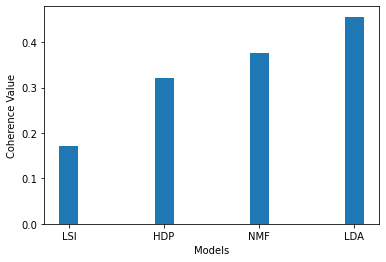

In [42]:
# Plot for visual comparison of coherence values
evaluate_bar_graph([hdp_coherence, lsi_coherence, nmf_coherence, lda_coherence], ['LSI', 'HDP', 'NMF', 'LDA'])
# According to the output, LDA outperforms NMF, LSI and HDP
# Now it's time to perform LDA and NMF using SciKit-Learn

TOPIC MODELING WITH SCI-KIT LEARN: LDA and NMF

We will be using SciKitLearn to perform:
LDA (based on TF) and Non-Negative Matrix Factorization (based on TF-IDF)
https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [ ]:
# WORD WEIGHTING: Count Vectorizer Parameters in sci-kit learn
"""
count_vectorizer = CountVectorizer(
                             # input='content',                # content == list of items (strings or bytes)
                             # analyzer='word',                # accepts to pass a callable, default='word'
                             min_df=10,                        # minimum number of occurences of a word 
                             max_df=0.95,                      # maximum percentage of occurences
                             # stop_words='english',           # only if analyzer=='word', default=None
                             # tokenizer=None,                 # only if analyzer=='word', callable, default=None
                             # lowercase=False,                # default=True
                             # token_pattern='[a-zA-Z0-9]+[_-]*[a-zA-Z0-9]*[_-]*[a-zA-Z0-9]*',  # or '[a-zA-Z0-9]{3,}', only if analyzer=='word', default='(?u)\\b\\w\\w+\\b'
                             # strip_accents=None,             # default=None
                             # preprocessor=None,              # only if analyzer is not a callable, default=None
                             # ngram_range=(1,3),              # only if analyzer is not a callable, default=(1,1)
                             max_features=None,                # Ignored if vocabulary!=None, max n of unique words, default=None (i.e., considers all words),
                             # vocabulary=None                 # id2word is a Gensim dictionary, Default=None, if != None, max_features is ignored
                             # binary=False                    # default=False, if True, all non zero counts are set to 1 (suitable for classification, e.g., Bernoulli Naive Bayes)
                            )
"""

In [43]:
# We create this numpy array object for our analyses
processed_text = df['processed'].values

In [44]:
maximum_features = None # Let's use default unless you have computational limitations or other reason
# both max_df=0.95 and min_df=2, coupled with maximum_features=None, will increase/decrease dimensionality
# LDA can only use raw term counts because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=maximum_features)

In [45]:
tf_vectorizer

CountVectorizer(max_df=0.95, min_df=2)

In [46]:
# Learn a vocabulary dictionary of all tokens in the raw document (fit)
# And return document-term matrix (transform)
tf = tf_vectorizer.fit_transform(processed_text)

In [47]:
# Array mapping from feature integer indices to feature names
tf_feature_names = tf_vectorizer.get_feature_names()

In [48]:
display(tf.shape)

(7899, 10722)

Finding the best LDA model parameters (ensemble learning with GridSearchCV)
Exhaustive Grid Seach (GridSearchCV) exhaustively considers all parameter combinations
https://scikit-learn.org/stable/modules/grid_search.html

In [49]:
# Based on the previous comparison (LSI, HDP, NMF, LDA), let's try with different numbers of topics:
n_topics = [10, 15, 20]
"""
# I did test different number of topics (between 10 and 30) using this script:
# WARNING: it takes much longer
n_topics = []
for i in range (10,31):
    n_topics.append(i)
print(n_topics)
"""

'\n# I did test different number of topics (between 10 and 30) using this script:\n# WARNING: it takes much longer\nn_topics = []\nfor i in range (10,31):\n    n_topics.append(i)\nprint(n_topics)\n'

In [51]:
# NOTE: This step takes a while
# Define Search Param
search_params = {'n_components': n_topics, 'learning_decay': [.5, .6, .7, .8, .9]}

# Initiating the LDA Model
lda_init = LatentDirichletAllocation()

# Initating Sci-kit Learn Grid Search Class (GridSearchCV)
model = GridSearchCV(lda_init, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'n_components': [10, 15, 20]})

In [52]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf))

# DONE! Based on the output, the best LDA model has these parameters:
# 'learning_decay': 0.5, 'n_components': 10

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -1125820.412502999
Model Perplexity:  1098.1425104425605


In [53]:
# Get Log Likelihoods from Grid Search Output
log_likelihoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelihoods_6 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.6]
log_likelihoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelihoods_8 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.8]
log_likelihoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

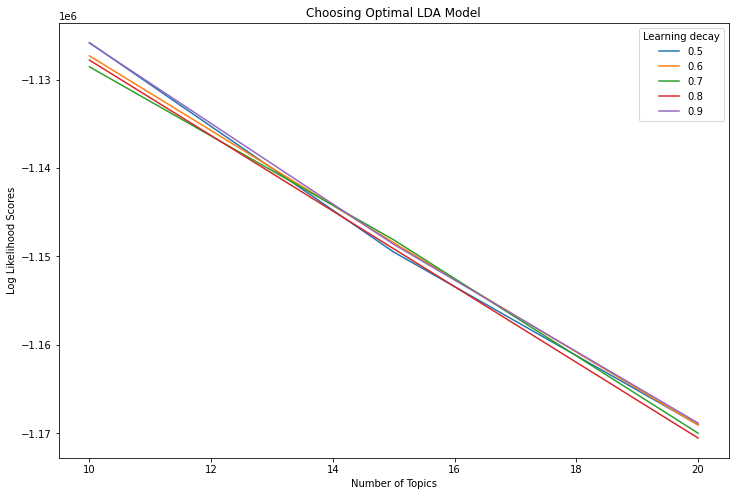

In [54]:
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelihoods_5, label='0.5')
plt.plot(n_topics, log_likelihoods_6, label='0.6')
plt.plot(n_topics, log_likelihoods_7, label='0.7')
plt.plot(n_topics, log_likelihoods_8, label='0.8')
plt.plot(n_topics, log_likelihoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Number of Topics")
plt.ylabel("Log Likelihood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [55]:
# DECOMPOSITION: LDA with the best parameters found in the previous step
lda_model = LatentDirichletAllocation(
                n_components=k,             # Number of topics
                # max_iter=10,              # Maximum number of iterations default=10
                learning_method='online',   # Only in fit method: 'online' uses mini-batches, so it's faster than batch for large datasets
                learning_decay=0.5,         # or 'kappa', it controls learning rate in the online learning method
                learning_offset=50.,        # or 'tau_0', it downweights early iterations in the online learning method
                random_state=42,            # For reproducible results across multiple function calls, default=None (i.e., different results)
                # batch_size=128,           # only in online method, n docs in each learning iteration, default=128
                # evaluate_every=-1,        # Only in fit method: computes perplexity every n iterations, default=0 (i.e, don't)
                # perp_tol=1e-1             # Only when evaluate_every > 0, default=1e-1
                # mean_change_tol=1e-3      # Stopping tolerance for updating document/topic distribution in the E-step, default=1e-3
                n_jobs = -1                 # n jobs in the E-step, -1 == Use all available CPUs, default=None
                # max_doc_update_iter=100   # Max n iterations for updating document/topic distribution in the E-step, default=100
                # doc_topic_prior=None      # default=None (i.e., 1 / n_components, document/topic distribution, called theta or alpha)
                # topic_word_prior=None     # default=None (i.e., 1 / n_components, topic/word distribution, called beta or eta)
                # total_samples             # only used in partial_fit method
                # verbose=0                 # Verbosity level, default=0
                )

# Show LDA model attributes
print(lda_model)

LatentDirichletAllocation(learning_decay=0.5, learning_method='online',
                          learning_offset=50.0, n_jobs=-1, random_state=42)


In [56]:
lda_fit_model = lda_model.fit(tf) #fit method

In [57]:
# Log-likelihood: The higher the better
print("Log Likelihood: ", lda_fit_model.score(tf))

# Perplexity: The lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_fit_model.perplexity(tf))

# See model parameters
pprint(lda_fit_model.get_params())

Log Likelihood:  -5154399.7375677135
Perplexity:  1171.8615107458975
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.5,
 'learning_method': 'online',
 'learning_offset': 50.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 42,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [ ]:
# WORD WEIGHTING: TF-IDF Vectorizer Parameters in sci-kit learn
"""
tfidf_vectorizer = TfidfVectorizer(
                             # input='content',                # content == list of items (strings or bytes)
                             # encoding='utf-8'                # default='utf-8'
                             # strip_accents=None,             # default=None
                             # lowercase=True,                 # default=True
                             # strip_accents='unicode'         # default=None
                             # preprocessor=None,              # callable, only if analyzer is not a callable, default=None
                             # tokenizer=None,                 # only if analyzer=='word', callable, default=None
                             # analyzer='word',                # accepts to pass a callable, default='word'
                             min_df=10,                        # minimum number of occurences of a word 
                             max_df=0.95,                      # maximum percentage of occurences
                             # stop_words='english',           # only if analyzer=='word', default=None, you can pass a list too
                             # token_pattern='[a-zA-Z0-9]+[_-]*[a-zA-Z0-9]*[_-]*[a-zA-Z0-9]*',  # or '[a-zA-Z0-9]{3,}', only if analyzer=='word', default='(?u)\\b\\w\\w+\\b'
                             # ngram_range=(1,3),              # only if analyzer is not a callable, default=(1,1)
                             max_features=None,                # Ignored if vocabulary!=None, max n of unique words, default=None (i.e., considers all words),
                             # vocabulary=None                 # id2word is a Gensim dictionary, Default=None, if != None, max_features is ignored
                             # binary=False                    # default=False, if True, all non zero counts are set to 1. Very short texts are likely to have noisy tf-idf values while binary occurences is more stable.
                             # norm='l2'                       # default='l2', each output row will have unit norm (l2 or l1)
                             # smooth_idf=False                # default=False, prevents zero division by adding 1 to document frequencies
                             # sublinear_tf=False              # default=False, applies sublinear tf scaling: replaces tf with 1 + log(tf)
                            )
"""

In [58]:
# TF-IDF VECTORIZATION PARAMETERS FOR NMF:
# We set before: maximum_features = None # default
# TF-IDF Vectorization parameters for NMF (NMF is able to use tf-idf)
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=maximum_features)

In [59]:
tfidf = tfidf_vectorizer.fit_transform(processed_text)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [60]:
display(tfidf.shape)

(7899, 10722)

In [ ]:
"""
NMF PARAMETERS:
                NMF(
                # n_components=k             # number of topics to extract (int or None), if not set, all features are kept
                # init=None                  # default=None ('nndsvd' if n_components <= min(n_samples, n_features), 
                                               otherwise random), 
                                               'random' (non-negative random matrices, scaled with sqrt(X.mean()/n_components)), 
                                               'nndsvd' (non-negative double singular value decomposition: initialization (better for sparseness)),
                                               'nndsvda' (nndsvd with zeros filled with the average of X: better when sparsity is not desired)
                                               'nndsvdar' (nndsvd with zeros filled with small random values: generally faster, 
                                                           less accurate alternative to NNDSVDa for when sparsity is not desired)
                                               'custom' (use custom matrices W and H)

                # solver='mu'                 # 'cd' (Coordinate Descent solver), 'mu' (Multiplicative Update solver)
                # beta_loss='frobenius'       # use only in 'mu' solver; Beta divergence to be minimized, measuring the distance between X and the dot product WH.
                                                float or string: 
                                                string must be in {'frobenius', 'kullback-leibler', 'itakura-saito'}
                                                Values different from 2 ('frobenius') and 1 ('kullback-leibler'), lead to significantly slower fit.
                                                For beta_loss <=0 ('itakura-saito'), the input matrix X cannot contain zeros.
                # tol=1e-4                    # float, default=1e-4; tolerance of the stopping condition
                # max_iter=200                # default=200
                # random_state=43             # Used for initialisation (when init=='nndsvdar' or 'random'),
                                                and in Coordinate Descent solver.
                # alpha=0                     # double, default=0; constant that multiplies the regularization terms. 0 == no regularization.
                # l1_ratio=0                  # double, default=0; the regularization mixing parameter, with 0 <= l1_ratio <= 1
                                                For l1_ratio=0 the penalty is an elementwise L2 (aka Frobenius norm).
                                                For l1_ratio=1 the penalty is an elementwise L1.
                                                For 0 < l1_ratio < 1 the penaltyis a combination of L1 and L2
                # verbose=False               # default=False, whether to be verbose
                # shuffle=False               # default=False, if True, randomize the order of coordinates in the CD solver
                )
# References:
Cichoki, A. & Ann-Huy, P. H. A. N. (2009). Fast local algorithms for large scale nonnegative matrix and tensor factorizations.
IEICE Transactions on Fundamentals of Electronics, Communications, and Computer Sciences, 92(3), 708-721.

Fevotte, C. & Idier, J. (2011). Algorithms for nonnegative matrix factorization with the beta divergence. 
Neural Computation, 23(9)

"""

In [61]:
# Run NMF
# nmf = NMF(n_components=no_topics, random_state=43,  alpha=0.1, l1_ratio=0.5)
# nmf_output = nmf.fit_transform(tfidf)
nmf_param = NMF(n_components=k, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd') # init='nndsvd'

In [62]:
nmf_fit = nmf_param.fit(tfidf) # fit method

In [63]:
nmf_weights = nmf_fit.components_
lda_weights = lda_fit_model.components_

In [64]:
# Function do display topics  words and their weights
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights, sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])
    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]
    return topics

In [65]:
# Function to print components of all the topics
def print_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw

In [66]:
# Function to print topic terms
def get_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     num_terms=None):
    topic_terms = []
    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]
        topic_terms.append(topic[:num_terms] if num_terms else topic)
    return topic_terms

In [67]:
# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [68]:
# Show NMF topics with their weights
topics = get_topics_terms_weights(nmf_weights, tfidf_feature_names)
print_topics_udf(topics, total_topics=10, num_terms=10, display_weights=True)

Topic #1 with weights
[('eat', 2.41), ('disorder', 2.29), ('eating', 1.16), ('symptom', 0.91), ('self', 0.83), ('score', 0.8), ('high', 0.7), ('factor', 0.69), ('risk', 0.65), ('sample', 0.62)]
Topic #2 with weights
[('body', 3.73), ('image', 1.98), ('dissatisfaction', 1.46), ('size', 0.67), ('disturbance', 0.44), ('ideal', 0.44), ('esteem', 0.43), ('girl', 0.42), ('appearance', 0.4), ('self', 0.37)]
Topic #3 with weights
[('bed', 4.09), ('obese', 0.56), ('binge', 0.48), ('individual', 0.28), ('disorder', 0.27), ('obesity', 0.23), ('criterion', 0.22), ('subject', 0.19), ('psychopathology', 0.18), ('diagnostic', 0.16)]
Topic #4 with weights
[('weight', 3.95), ('loss', 1.16), ('bmi', 0.9), ('overweight', 0.73), ('gain', 0.71), ('obese', 0.68), ('obesity', 0.67), ('normal', 0.49), ('control', 0.48), ('diet', 0.47)]
Topic #5 with weights
[('patient', 3.48), ('nervosa', 2.04), ('anorexia', 1.79), ('bulimia', 1.0), ('case', 0.81), ('disorder', 0.54), ('group', 0.51), ('clinical', 0.43), ('bu

In [69]:
# Show LDA topics with their weights
topics = get_topics_terms_weights(lda_weights, tf_feature_names)
print_topics_udf(topics, total_topics=10, num_terms=10, display_weights=True)

Topic #1 with weights
[('eat', 3294.51), ('disorder', 2104.52), ('woman', 1964.32), ('eating', 1343.05), ('female', 1330.6), ('self', 1306.7), ('attitude', 1279.8), ('male', 1145.7), ('girl', 1106.03), ('risk', 1067.94)]
Topic #2 with weights
[('treatment', 6857.48), ('patient', 6562.44), ('disorder', 5323.93), ('nervosa', 3902.8), ('anorexia', 3005.68), ('eat', 1862.23), ('outcome', 1664.01), ('eating', 1474.74), ('follow', 1280.74), ('clinical', 1259.25)]
Topic #3 with weights
[('eat', 9004.37), ('disorder', 8665.1), ('eating', 4991.2), ('binge', 3061.04), ('score', 2445.37), ('group', 2437.8), ('result', 2350.01), ('symptom', 2256.63), ('high', 2227.5), ('self', 2132.34)]
Topic #4 with weights
[('food', 1475.5), ('disorder', 867.25), ('eat', 849.91), ('result', 750.0), ('self', 704.12), ('participant', 702.17), ('individual', 680.18), ('group', 650.2), ('model', 647.3), ('control', 646.86)]
Topic #5 with weights
[('patient', 723.3), ('anorexia', 362.69), ('nervosa', 323.89), ('contr

In [70]:
# Displaying top words for each topic for each model (NMF and LDA)
no_top_words = 10
print('NMF results - Top ' + str(no_top_words) + ' words for each cluster:' + '\n')
display_topics(nmf_fit, tfidf_feature_names, no_top_words)
print('\n' + 'LDA results - Top ' + str(no_top_words) + ' words for each cluster:' + '\n')
display_topics(lda_fit_model, tf_feature_names, no_top_words)
# Based on the output, we keep NMF rather than LDA

NMF results - Top 10 words for each cluster:

Topic 0:
eat disorder eating symptom self score high factor risk sample
Topic 1:
body image dissatisfaction size disturbance ideal esteem girl appearance self
Topic 2:
bed obese binge individual disorder obesity criterion subject psychopathology diagnostic
Topic 3:
weight loss bmi overweight gain obese obesity normal control diet
Topic 4:
patient nervosa anorexia bulimia case disorder group clinical bulimic present
Topic 5:
treatment outcome therapy cbt intervention change program follow improvement fbt
Topic 6:
child family parent mother adolescent parental maternal girl fbt father
Topic 7:
binge eating episode eat purge food frequency eater behavior report
Topic 8:
woman man bulimic group bulimia report black white pregnancy young
Topic 9:
bn ednos bulimia nervosa pd lifetime disorder purge rate compare

LDA results - Top 10 words for each cluster:

Topic 0:
eat disorder woman eating female self attitude male girl risk
Topic 1:
treatment 

In [ ]:
####################################################
### IN THE REST OF ANALYSES WE WILL BE USING NMF ###
####################################################

In [71]:
# Create Document-Topic Matrix for NMF
nmf_output = nmf_fit.transform(tfidf)
# Which is basically the same as:
# nmf_output = nmf_model.fit_transform(tfidf)

In [72]:
###########################################
### NMF - DOMINANT TOPIC IN EACH RECORD ###
###########################################

# Column names
nmf_topic_names = ["NMF_Topic_" + str(i) for i in range(k)]# from best_lda_model.n_components

# Index names
doc_id = ["Doc_" + str(i) for i in range(len(df['Abstract']))]

# We build a Pandas data frame
nmf_topics_df = pd.DataFrame(np.round(nmf_output, 2), columns=nmf_topic_names, index=doc_id)

# Get dominant topic for each document
nmf_topic = np.argmax(nmf_topics_df.values, axis=1)

# Populating columns
nmf_topics_df['nmf_topic'] = nmf_topic

In [73]:
# Some color for our dataframe
def red_color(val):
    color = 'red' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

# Some color for our dataframe
def blue_color(val):
    color = 'blue' if val > 0 else 'black'
    return 'color: {col}'.format(col=color)

def bolder(val):
    weight = 650 if val > 0 else 350
    return 'font-weight: {weight}'.format(weight=weight)

# Applying this color to our data frame
NMF_df_dominant_topics = nmf_topics_df.head(15).style.applymap(blue_color).applymap(bolder)

In [74]:
# Show data frame with dominant topic columns
NMF_df_dominant_topics

,NMF_Topic_0,NMF_Topic_1,NMF_Topic_2,NMF_Topic_3,NMF_Topic_4,NMF_Topic_5,NMF_Topic_6,NMF_Topic_7,NMF_Topic_8,NMF_Topic_9,nmf_topic
Doc_0,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,0.000000,0.000000,7
Doc_1,0.000000,0.000000,0.000000,0.050000,0.000000,0.060000,0.010000,0.000000,0.000000,0.000000,5
Doc_2,0.010000,0.000000,0.000000,0.020000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,3
Doc_3,0.020000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,5
Doc_4,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0
Doc_5,0.020000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0
Doc_6,0.000000,0.000000,0.000000,0.030000,0.000000,0.030000,0.000000,0.040000,0.000000,0.000000,7
Doc_7,0.030000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0
Doc_8,0.010000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.010000,4
Doc_9,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,7


In [75]:
df_nmf_topic_distribution = nmf_topics_df['nmf_topic'].value_counts().reset_index(name="Number of Documents")
df_nmf_topic_distribution.columns = ['NMF Topic Number', 'Number of Documents']
df_nmf_topic_distribution

,NMF Topic Number,Number of Documents
0,0,2809
1,4,1136
2,5,928
3,3,735
4,1,671
5,6,379
6,7,356
7,8,328
8,9,282
9,2,275


In [76]:
# Function to show top n keywords for each topic:
def show_topics(model, features, words):
    keywords = np.array(features)
    topic_keywords = []
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [77]:
nmf_topic_keywords = show_topics(nmf_fit, tfidf_feature_names, 10)

# NMF Topic-Keywords Dataframe
df_nmf_topic_keywords = pd.DataFrame(nmf_topic_keywords)
df_nmf_topic_keywords.columns = ['Keyword_'+str(i) for i in range(df_nmf_topic_keywords.shape[1])]
df_nmf_topic_keywords.index = ['NMF_Topic_'+str(i) for i in range(df_nmf_topic_keywords.shape[0])]
df_nmf_topic_keywords

,Keyword_0,Keyword_1,Keyword_2,Keyword_3,Keyword_4,Keyword_5,Keyword_6,Keyword_7,Keyword_8,Keyword_9
NMF_Topic_0,eat,disorder,eating,symptom,self,score,high,factor,risk,sample
NMF_Topic_1,body,image,dissatisfaction,size,disturbance,ideal,esteem,girl,appearance,self
NMF_Topic_2,bed,obese,binge,individual,disorder,obesity,criterion,subject,psychopathology,diagnostic
NMF_Topic_3,weight,loss,bmi,overweight,gain,obese,obesity,normal,control,diet
NMF_Topic_4,patient,nervosa,anorexia,bulimia,case,disorder,group,clinical,bulimic,present
NMF_Topic_5,treatment,outcome,therapy,cbt,intervention,change,program,follow,improvement,fbt
NMF_Topic_6,child,family,parent,mother,adolescent,parental,maternal,girl,fbt,father
NMF_Topic_7,binge,eating,episode,eat,purge,food,frequency,eater,behavior,report
NMF_Topic_8,woman,man,bulimic,group,bulimia,report,black,white,pregnancy,young
NMF_Topic_9,bn,ednos,bulimia,nervosa,pd,lifetime,disorder,purge,rate,compare


TOPIC EVOLUTION OVER TIME (TRENDS)

In [79]:
nmf_topics_df['Timestamp'] = pd.to_datetime(df['Year'].values, format='%Y') #%Y%m%d%H%M%S

In [80]:
nmf_topics_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7899 entries, Doc_0 to Doc_7898
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   NMF_Topic_0  7899 non-null   float64       
 1   NMF_Topic_1  7899 non-null   float64       
 2   NMF_Topic_2  7899 non-null   float64       
 3   NMF_Topic_3  7899 non-null   float64       
 4   NMF_Topic_4  7899 non-null   float64       
 5   NMF_Topic_5  7899 non-null   float64       
 6   NMF_Topic_6  7899 non-null   float64       
 7   NMF_Topic_7  7899 non-null   float64       
 8   NMF_Topic_8  7899 non-null   float64       
 9   NMF_Topic_9  7899 non-null   float64       
 10  nmf_topic    7899 non-null   int64         
 11  Timestamp    7899 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 802.2+ KB


In [81]:
nmf_topics_df['Timestamp'].min(), nmf_topics_df['Timestamp'].max()

(Timestamp('1981-01-01 00:00:00'), Timestamp('2020-01-01 00:00:00'))

In [82]:
nmf_topics_df = nmf_topics_df.sort_values('Timestamp')

In [83]:
nmf_topics_df.isnull().sum()

NMF_Topic_0    0
NMF_Topic_1    0
NMF_Topic_2    0
NMF_Topic_3    0
NMF_Topic_4    0
NMF_Topic_5    0
NMF_Topic_6    0
NMF_Topic_7    0
NMF_Topic_8    0
NMF_Topic_9    0
nmf_topic      0
Timestamp      0
dtype: int64

In [84]:
# Dataframe topics names list
df_topic_names = ['topic_' + str(i) + '_df' for i in range(k)]

for i in range(k):
    df_topic_names[i] = nmf_topics_df.groupby('Timestamp')[nmf_topic_names[i]].sum().reset_index()
    df_topic_names[i] = df_topic_names[i].set_index('Timestamp')

In [85]:
y_list = ['y' + str(i) for i in range(k)]
for i in range(k):
    y_list[i] = df_topic_names[i][nmf_topic_names[i]]

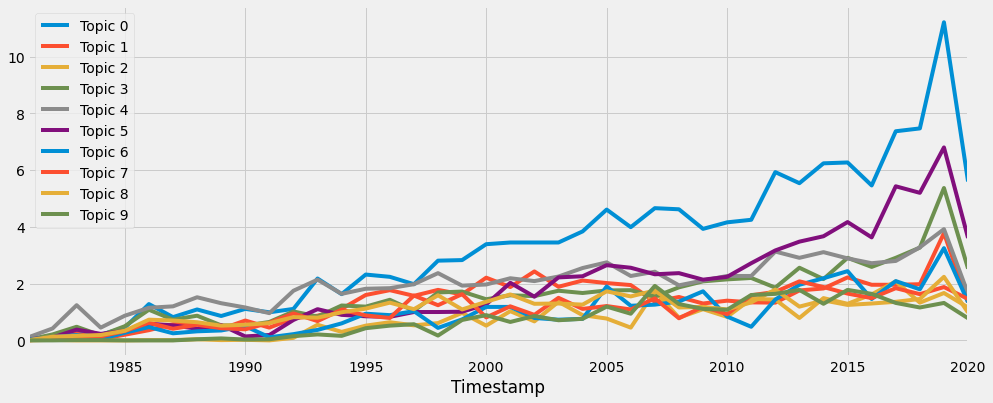

In [86]:
# Plot style
plt.style.use('fivethirtyeight')
for i in range(k):
    topic_label = 'Topic ' + str(i)
    y_list[i].plot(figsize=(15, 6), label=topic_label)
plt.legend()
# Show plot
plt.savefig('eating_disorders_literature_topic_trends.tiff', format="tiff", dpi=300)
plt.show()